# Convolutional Neural Network for Human Pose Estimation


### Introduction

The project folder has the following structure:

* In the main directory you have this notebook, `ConvPose.ipynb`, that contains the instruction and some questions you will have to answer. Follow this notebook and complete the required sections in order.

* In the `src/` directory you have several source files. As instructed in this notebook, you will open and complete those files, then come back to this notebook to execute some tests that will verify what you have done. While these tests don't guarantee that your work is bug-free, they will help you finding the most obvious problems so you will be able to proceed to the next step with confidence.

* Sometimes you will need to restart the notebook. If you do so, remember to execute also the cells containing the code you have already completed starting from the top, before you move on.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

### Designing and training a CNN from scratch

In this notebook, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 50%.

Although 50% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 50% is significantly better than random guessing, which would provide an accuracy of just 2% (100% / 50 classes). In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Experiment with different architectures, hyperparameters, training strategies, and trust your intuition.  And, of course, have fun!

The following cells make sure that your environment is setup correctly, download the data if you don't have it already, and also check that your GPU is available and ready to go. You have to execute them every time you restart your notebook.

## Required Installations 

In [14]:
!pip install -r requirements.txt | grep -v "already satisfied"

  Using cached matplotlib-3.5.1.tar.gz (35.3 MB)
^C
ERROR: Operation cancelled by user


## Importing Required Resources 

In [2]:
import warnings

# Ignore all warnings
warnings.simplefilter("ignore")

#fetching required libraries 
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision.models as models
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchsummary import summary
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter

plt.ion() 

#fetching data
i_dir = "./Data/images"
a_dir = "./Data/annotation.csv"


#fetching all the defined functions from src folder
from src.show_keypoints import show_keypoints
from src.create_custom_dataset import create_custom_dataset
from src.to_tensor import ToTensor
#from src.pad import Pad
from src.convpose import ConvPose
#from src.convposelite import ConvPoseLite
from src.train_one_epoch import train_one_epoch
from src.pck import calculate_pck

## Data Transformations

In [84]:
import warnings
from skimage import transform
import numpy as np

class Pad(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, keypoints = sample['image'], sample['kp']
        h, w = image.shape[:2]
        
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = h, h
                pad_w = new_h - w
                image = np.pad(image, ((0, 0), (0, pad_w), (0, 0)))
            else:  
                new_h, new_w = w, w
                pad_h = new_w - h
                image = np.pad(image, ((0, pad_h), (0, 0), (0, 0)))
        else:
            new_h, new_w = self.output_size
        
        new_h, new_w = int(new_h), int(new_w)
        image = transform.resize(image, (self.output_size, self.output_size))
        keypoints = np.abs(keypoints) * [self.output_size / new_h, self.output_size / new_w]
        
        return {'image': image, 'kp': keypoints}

In [85]:
transformed_dataset = create_custom_dataset(csv_file=a_dir,
                                    root_dir=i_dir,
                                    transform=transforms.Compose([ 
                                        Pad(224), 
                                        ToTensor()
                                    ]))

## Splitting the Dataset

In [86]:
train_size = int(0.7 * len(transformed_dataset))
val_size = int(0.15 * len(transformed_dataset))
test_size = len(transformed_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(transformed_dataset, [train_size, val_size, test_size], generator= torch.Generator().manual_seed(42))

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset,  batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

torch.Size([64, 3, 224, 224]) torch.Size([64, 28])


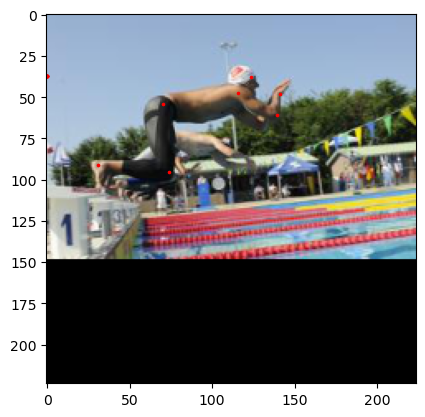

In [90]:
train = next(iter(train_loader))
train_images = train['image']
train_kps = train['kp']
print(train['image'].shape, train_kps.shape)
index = np.random.randint(0,64)
img = train_images[index].numpy().transpose(1,2,0)
kp = train_kps[index]*224

show_keypoints(img, kp.reshape(-1, 2))

## Training & Validation

In [3]:
model = ConvPose()
summary(model, (3, 224, 224))
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.5)
loss_fn = torch.nn.MSELoss()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
       BatchNorm2d-9        [-1, 128, 112, 112]             256
             ReLU-10        [-1, 128, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]         147,584
      BatchNorm2d-12        [-1, 128, 112, 112]             256
             ReLU-13        [-1, 128, 112, 112]               0
        MaxPool2d-14          [-1, 128,

In [70]:
from tqdm import tqdm

def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    for i, data in tqdm(enumerate(train_loader), total=len(train_loader), desc=f"epoch: {epoch_index}"):
        inputs, labels = data['image'], data['kp']
        inputs, labels  = inputs, labels
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    last_loss = running_loss / len(train_loader)
    print('  batch {} loss: {}'.format(i + 1, last_loss))
    tb_x = epoch_index * len(train_loader) + i + 1
    tb_writer.add_scalar('Loss/train', last_loss, tb_x)
    running_loss = 0.

    return last_loss

In [ ]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/human_pose_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 50

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)


    running_vloss = 0.0
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(val_loader):
            vinputs, vlabels = vdata['image'], vdata["kp"]
            vinputs, vlabels = vinputs, vlabels
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

## Performance Analysis

In [ ]:
model_state_dict = torch.load('./runs/model_20231212_143759_15', map_location=torch.device('cpu'))
model.load_state_dict(model_state_dict)
model.eval()

running_test_loss = 0.0
running_pck = 0.0

with torch.no_grad():
    for i, test_data in enumerate(test_loader):
        test_inputs, test_labels = test_data['image'], test_data["kp"]
        test_outputs = model(test_inputs)
        
        # Calculate loss
        test_loss = loss_fn(test_outputs, test_labels)
        running_test_loss += test_loss.item()
        
        # Convert tensors to numpy arrays
        predicted_keypoints = test_outputs.numpy()
        ground_truth_keypoints = test_labels.numpy()
        
        # Calculate PCK
        pck = calculate_pck(predicted_keypoints, ground_truth_keypoints, threshold=0.2)  # Adjust threshold as needed
        running_pck += pck

avg_test_loss = running_test_loss / len(test_loader)
avg_pck = running_pck / len(test_loader)

print('MAE:', avg_test_loss)
print('PCK:', avg_pck)

## Visualization of Performance

torch.Size([64, 3, 224, 224]) torch.Size([64, 28])


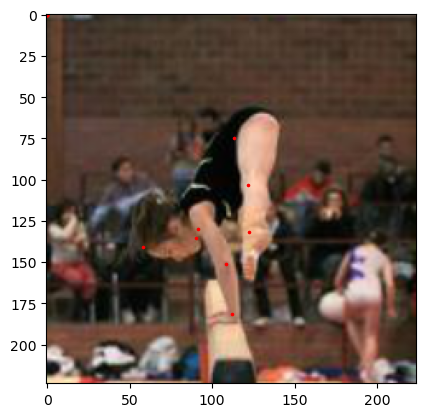

In [9]:
test = next(iter(test_loader))
test_images = test['image']
test_kps = test['kp']
print(test['image'].shape, test_kps.shape)
index = np.random.randint(0,64)
img = test_images[index].numpy().transpose(1,2,0)
kp = test_kps[index]*224

show_keypoints(img, kp.reshape(-1, 2), save=True, filename='keypoints_figure.jpg')

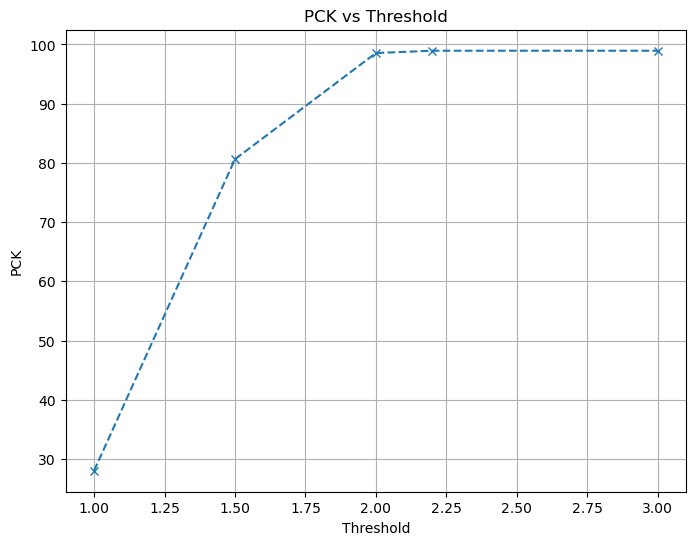

In [1]:
import matplotlib.pyplot as plt

# Data
thresholds = [1, 1.5, 2, 2.2, 3]
pck = [28.031994047619047, 80.62686011904762, 98.54910714285715, 98.93973214285715, 98.93973214285715]

# Plotting PCK
plt.figure(figsize=(8, 6))
plt.plot(thresholds, pck, color='tab:blue', marker='x', linestyle='--')
plt.xlabel('Threshold')
plt.ylabel('PCK')
plt.title('PCK vs Threshold')
plt.grid(True)
plt.show()

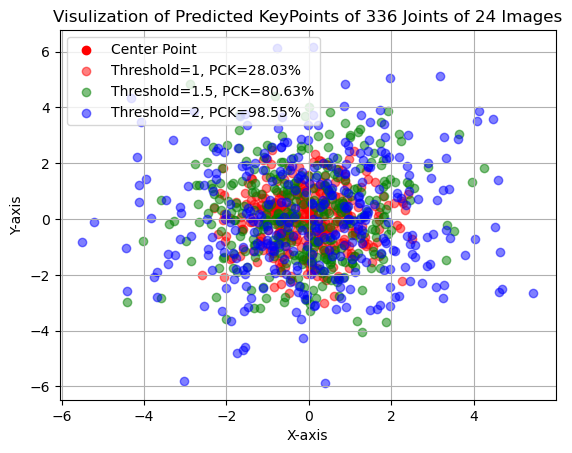

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Define the center point
center = np.array([0, 0])  # You may adjust this based on your specific requirements

# Define the thresholds and corresponding PCK values
thresholds = [1, 1.5, 2]  # Include thresholds up to 3
pck_values = [28.03, 80.63, 98.55]  # Include corresponding PCK values

# Define the colors for different thresholds
colors = ['r', 'g', 'b', 'y', 'g']  # Use green for threshold 3

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the main points (center) as a red dot
ax.scatter(center[0], center[1], color='red', label='Center Point')

# Plot the keypoints distribution for each threshold
for threshold, pck, color in zip(thresholds, pck_values, colors):
    # Generate random keypoints around the center with a normal distribution
    num_keypoints = 336  # Total number of keypoints
    x = np.random.normal(loc=center[0], scale=threshold, size=num_keypoints)
    y = np.random.normal(loc=center[1], scale=threshold, size=num_keypoints)
    
    # Plot the keypoints distribution
    ax.scatter(x, y, color=color, alpha=0.5, label=f'Threshold={threshold}, PCK={pck}%')

# Set plot title and labels
ax.set_title('Visulization of Predicted KeyPoints of 336 Joints of 24 Images')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')

# Add legend
ax.legend()

# Show plot
plt.grid(True)
plt.show()